In [1]:
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

In [2]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -qU "langchain[google-genai]" --use-deprecated=legacy-resolver

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install -qU langchain-google-genai

Note: you may need to restart the kernel to use updated packages.


In [5]:
%%skip
%pip install protobuf==5.26.1

In [6]:
%pip install -qU langchain-chroma 

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.73.1 requires protobuf<7.0.0,>=6.30.0, but you have protobuf 5.29.5 which is incompatible.


In [7]:
%%skip
%pip uninstall -y protobuf

In [8]:
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [9]:
%pip install urllib3==1.26.18

Note: you may need to restart the kernel to use updated packages.


In [10]:
%pip install -qU langchain_community pymupdf

Note: you may need to restart the kernel to use updated packages.


In [11]:
import getpass
import os
from dotenv import load_dotenv
load_dotenv()

#Here we just load in all the API keys and choose what AI model we want to run. 
#We setup the vector store and embeddings to later store our indices into to retrieve later.

os.environ["LANGSMITH_TRACING"] = "true"
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter Langsmith API Key")

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_chroma import Chroma

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

print("YAY")

YAY


In [12]:
#Load papers 
from langchain_community.document_loaders import PyMuPDFLoader

file_path = "dnutg/paper1.pdf"
loader = PyMuPDFLoader(file_path, mode="page", 
                        extract_tables="markdown",
                      )
docs = loader.load()

In [13]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, #chunk size
    chunk_overlap=200, #chunk overlap
    add_start_index=True, #track index
)
all_splits = text_splitter.split_documents(docs)
print(f"Split dem cheeks boi (into a diclosed number of subdocs): {len(all_splits)} sub-documents.")

Split dem cheeks boi (into a diclosed number of subdocs): 48 sub-documents.


In [14]:
document_ids = vector_store.add_documents(documents=all_splits)
print(document_ids[:3])

['5654e848-3bbc-4b30-94b5-97c268c745c1', '16a722d2-9926-42d9-b842-a135c303bcbe', '30762f31-5e67-4738-94bf-861a2134857e']


In [15]:
from langchain_core.prompts import ChatPromptTemplate

prompt_template = """You are a highly knowledgeable AI assistant specializing in cardiovascular health and medical research.
Your primary goal is to provide accurate, evidence-based answers to user questions about heart rate, heart health, and related medical conditions.

Answer the question ONLY based on the following context. If the answer cannot be found in the context, please respond to the best of your given ability with the context. You don't have to answer the question if you cannot, but try to give as much context to answering the question as possible. Do not make up information.

Context:
{context}

Question:
{question}
"""

prompt = ChatPromptTemplate.from_template(prompt_template)

sample_context = """
A study on resting heart rate found that a rate between 60-100 is normal.
"""

sample_question = "What is a good heart rate?"

prompt_value = prompt.invoke({"context":sample_context, "question":sample_question})

example_messages = prompt_value.to_messages()
assert len(example_messages) == 1
#print(example_messages[0].content)


In [16]:
#Query analysis: optimize user prompts to make sense to llm
total_docs = len(all_splits)
third = total_docs // 3
for i, doc in enumerate(all_splits):
    if i<third:
        doc.metadata["section"] = "begin"
    elif i<2*third:
        doc.metadata["section"] = "mid"
    else:
        doc.metadata["section"] = "end"


In [17]:
#update docs in the vector store
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [18]:
#define schema for search query using structured output
from typing import Literal
from typing_extensions import Annotated, List, TypedDict

class Search(TypedDict):
    """Search Query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["begin", "mid", "end"],
        ...,
        "Section to query."
    ]
    

In [19]:
#We use langGraph to tie together retrievel and generation into simpler process
#Makes it easier to update later + easy to trace steps of the application
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph

class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter = lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

#now make graph object that compiles all components into one
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

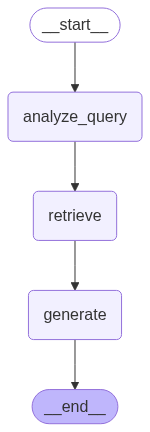

In [20]:
#workflow display
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:

#test app
result = graph.invoke({"question": "What is heart rate variability? Where is it commonly seen?"})
#print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Answer: Based on the context, heart rate variability measures were adjusted for age and heart rate. Higher heart rate, older age, beta-adrenergic blocking agent use, history of myocardial infarction or congestive heart failure, diuretic use, diastolic blood pressure 290 mm Hg, diabetes mellitus, consumption of three or more cups of coffee per day and smoking were associated with lower values of one or more heart rate variability measures, whereas longer processed times start time in the morning, frequent supraventricular and ventricular premature beats, female gender and systolic blood pressure Z160 mm Hg were associated with.

In addition to these two measures, 2-h SDNN was selected because it is conceptually a simpler measure of heart rate variability.


In [22]:
%%skip
#testing the app using diff method. This one is streaming
for step in graph.stream(
    {"question": "What is a heart?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

In [23]:
%%skip
#Uses stream tokens?? idk 
for message, metadata in graph.stream(
    {"question": "What is a heart rate variability?"}, stream_mode="messages"
):
    print(message.content, end="|")